In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

/Users/armelleleguelte/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.options.display.max_rows = None

## 1-Look for "communities" of providers in the Nashville/Davidson County CBSA. Make use of the Louvain community detection algorithm from Neo4j:

In [3]:
nash_final_mini = pd.read_csv('../data/nash_referrals_final_mini.csv')
nash_final_mini.shape

(6425, 12)

In [4]:
nash_final_mini.head(2)

,from_npi,to_npi,to_facility_name_normalised,from_physician,from_address,from_zip,from_classification,to_facility,to_address,to_zip,to_classification,patient_count
0,1013179860,1417938846,Macon County General Hospital,GARY YAWN,353 NEW SHACKLE ISLAND RD STE 300C,37083,Internal Medicine,"MACON COUNTY GENERAL HOSPITAL, INC.",204 MEDICAL DRIVE,37075,General Acute Care Hospital,71
1,1336126887,1417938846,Macon County General Hospital,ROBERT WEBB,353 NEW SHACKLE ISLAND RD,37083,Urology,"MACON COUNTY GENERAL HOSPITAL, INC.",204 MEDICAL DRIVE,37075,General Acute Care Hospital,55


### A- Prepare the file:

In [5]:
### prepare the file for the louvain algortithm (we only need npi and patient count)
final_mini = nash_final_mini[['from_npi', 'to_npi', 'patient_count']]

In [6]:
final_mini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425 entries, 0 to 6424
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   from_npi       6425 non-null   int64
 1   to_npi         6425 non-null   int64
 2   patient_count  6425 non-null   int64
dtypes: int64(3)
memory usage: 150.7 KB


In [7]:
### Save file
#final_mini.to_csv('../data/final_mini.csv', index=False)

### B-Data after Louvain Algorithm:

In [8]:
final_mini_louvain = pd.read_csv('../data/final_mini_louvain.csv')
final_mini_louvain.head()

,name,communityId
0,1003013947,4228
1,1003019902,4238
2,1003031261,4228
3,1003050972,4238
4,1003063314,4238


In [9]:
### Merge on from_npi (physician npi)
doc_mini = final_mini_louvain.merge(nash_final_mini, left_on='name', right_on='from_npi')

In [10]:
doc_mini = doc_mini[["name", "communityId", "patient_count", "from_classification", "from_zip", "to_classification"]]
doc_mini = doc_mini.rename(columns = {'from_zip': 'zip'})

In [11]:
doc_mini.shape

(6425, 6)

In [12]:
doc_mini.head()

,name,communityId,patient_count,from_classification,zip,to_classification
0,1003013947,4228,72,Orthopaedic Surgery,37203,General Acute Care Hospital
1,1003019902,4238,213,Psychiatry & Neurology,37232,General Acute Care Hospital
2,1003031261,4228,73,Orthopaedic Surgery,37203,General Acute Care Hospital
3,1003050972,4238,116,Internal Medicine,37232,General Acute Care Hospital
4,1003063314,4238,343,Family Medicine,37232,General Acute Care Hospital


### C- EDA of communities:

In [13]:
doc_mini.communityId.unique()

array([4228, 4238, 2536, 2796, 4220, 4239, 4233, 4241, 4232, 4230])

In [14]:
doc_mini_count = doc_mini.communityId.value_counts().reset_index()

In [15]:
doc_mini_count.columns = ['communityId', 'patient_count']

In [16]:
doc_mini_count.head(2)

,communityId,patient_count
0,4228,1696
1,4238,1516


In [17]:
community_counts = doc_mini_count.sort_values('patient_count', ascending = False)

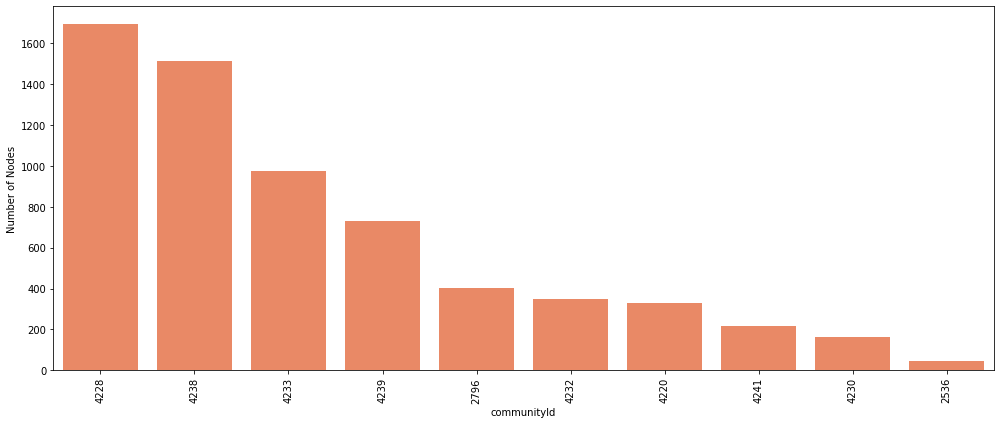

In [18]:
plt.figure(figsize = (14,6))
ax = sns.barplot(data = community_counts, x = 'communityId', y = 'patient_count', 
            order = community_counts['communityId'], color = 'coral')
for item in ax.get_xticklabels(): item.set_rotation(90)
plt.ylabel('Number of Nodes')
plt.tight_layout()

In [ ]:
#fig = px.scatter(doc_mini_count, x="index", y="communityId")
#fig.update(layout_showlegend=False)
#fig.show()

### D- What are the 3 major communities:

In [19]:
community_3_doc = doc_mini[doc_mini.communityId.isin([4228, 4238, 4233])]
community_3_doc.head(2)

,name,communityId,patient_count,from_classification,zip,to_classification
0,1003013947,4228,72,Orthopaedic Surgery,37203,General Acute Care Hospital
1,1003019902,4238,213,Psychiatry & Neurology,37232,General Acute Care Hospital


In [22]:
community_3 = community_3_doc.groupby(['communityId','zip'])['patient_count'].agg(['count']).reset_index()

In [23]:
community_3.head(2)

,communityId,zip,count
0,4228,37015,26
1,4228,37030,5


In [26]:
### Save file
community_3.to_csv('../data/community_3.csv', index=False)

**HCA community ID 4228:**

In [27]:
id4228_doc = doc_mini[doc_mini.communityId == 4228]

In [28]:
id4228_doc.head(2)

,name,communityId,patient_count,from_classification,zip,to_classification
0,1003013947,4228,72,Orthopaedic Surgery,37203,General Acute Care Hospital
2,1003031261,4228,73,Orthopaedic Surgery,37203,General Acute Care Hospital


In [29]:
id4228_doc_count = id4228_doc.groupby('zip')['patient_count'].agg('count')
id4228_doc_count = id4228_doc_count.to_frame().reset_index()

In [31]:
### Save file
id4228_doc_count.to_csv('../data/id4228_doc_count.csv', index=False)

In [32]:
### CommunityID and facility information
hosp_mini = final_mini_louvain.merge(nash_final_mini, left_on='name', right_on='to_npi')

In [33]:
id4228 = hosp_mini[hosp_mini.communityId == 4228]

In [34]:
id4228.to_facility_name_normalised.unique()

array(['Centennial Medical Center HCA', 'Ashland City Medical Center HCA',
       'TriStar Skyline Medical Center HCA',
       'Southern Hills Medical Center HCA', 'Summit Medical Center HCA',
       'StoneCrest Medical Center HCA'], dtype=object)

In [35]:
id4228.to_zip.unique()

array([37203, 37146, 37075, 37207, 37211, 37055, 37205, 37027, 37232,
       37076, 37090, 37209, 37167, 37208, 37064, 37215, 37129, 37174,
       37072, 37067, 37236, 37172, 37013, 37128, 37015, 37087, 37214,
       37228, 37212, 37066, 37083, 37115, 38401, 37073, 38474, 37188,
       37138, 37130, 37122, 37186, 37127, 37030, 37218, 37086])

**Vanderbilt community ID 4238:**

In [36]:
id4238 = hosp_mini[hosp_mini.communityId == 4238]

In [38]:
id4238.to_facility_name_normalised.unique()

array(['Vanderbilt University Medical Center'], dtype=object)

In [39]:
id4238.from_zip.unique()

array([37232, 37212])

In [40]:
id4238_doc = doc_mini[doc_mini.communityId == 4238]

In [41]:
id4238_doc_count = id4238_doc.groupby('zip')['patient_count'].agg('count')
id4238_doc_count = id4238_doc_count.to_frame().reset_index()

In [42]:
### Save file
id4238_doc_count.to_csv('../data/id4238_doc_count.csv', index=False)

**St Thomas hospital ID 4233:**

In [43]:
id4233_hosp = hosp_mini[hosp_mini.communityId == 4233]

In [45]:
id4233_hosp.to_facility_name_normalised.unique()

array(['Saint Thomas West Hospital', 'Saint Thomas Midtown Hospital'],
      dtype=object)

In [46]:
id4233_hosp.from_zip.unique()

array([37205, 37236])

In [47]:
id4233_doc = doc_mini[doc_mini.communityId == 4233]

In [48]:
id4233_doc_count = id4233_doc.groupby('zip')['patient_count'].agg('count')
id4233_doc_count = id4233_doc_count.to_frame().reset_index()

In [49]:
### Save file
id4233_doc_count.to_csv('../data/id4233_doc_count.csv', index=False)

### E-Test Louvain algorithm on 41k rows:

NB: with so many rows, it's more difficult to find well defined communities like the data with 6000+ rows.

In [ ]:
maxi = pd.read_csv("../data/nash_referrals_final_clean.csv")
maxi.head()

In [ ]:
final_maxi = maxi[['from_npi', 'to_npi', 'patient_count']]

In [ ]:
final_maxi.info()

In [ ]:
final_maxi = final_maxi.dropna(axis=0)

In [ ]:
### Save file
final_maxi.to_csv('../data/final_maxi.csv', index=False)

**Result from the louvain algorithm:**

In [ ]:
final_maxi_louvain = pd.read_csv('../data/final_maxi_louvain.csv')
final_maxi_louvain.head()

In [ ]:
merge_hospital_max = final_maxi_louvain.merge(maxi, left_on='name', right_on='to_facility')

In [ ]:
merge_hospital_max.communityId.unique()

In [ ]:
merge_hospital_max.communityId.value_counts()

In [ ]:
id6029 = merge_hospital_max[merge_hospital_max.communityId == 6029]

In [ ]:
id6029.to_facility.unique()